# CCE Moorings - Temporal Scales Analysis for Along and Cross-shelf Velocity

**Purpose**: Code for computing the mean autocorrelation function for scalar fields from CCE moorings.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr_optimize, compute_decor_scale_optimize
from spectra import spectrum1D_frequency, spectral_slope
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function

Set data analysis parameters

In [3]:
# Set processing parameters
option_mooring       = 'CCE1' # Specifies which mooring will analyzed. 
option_obs           = 'ADCP' # Specifies the observational instrumentation to process. Options include: 'CTD', 'CHL', 'ADCP'
option_grid          = 0      # Specifies whether the gridded product or the nearest neighbor depth-correct approach approach is used
option_plot          = 0 

# Set time and space parameters
T               = 1*(60)*(60)                         # Spcifies the time interval for model run. Units: seconds
estimator       = 'biased'                            # Specifies the approach for estimating the autocorrelation function  
start_time      = datetime(2015, 1, 1, 0, 0, 0)       # Specifies the start time of the event period  datetime(2016, 1, 1, 0, 0, 0) datetime(2025, 3, 12, 0, 0, 0)
end_time        = datetime(2015, 12, 31, 23, 59, 59)  # Specifies the end time of the event period        datetime(2025, 12, 31, 23, 59, 59)  datetime(2025, 6, 23, 0, 0, 0) 
event_time_bnds = [start_time, end_time]              # Specifies the event period

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 14

Load CCE processed data

In [5]:
# Set the file name and read in the data file
if option_grid == 1:
    filename_CCE = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_gridded_data.nc"
else:
    filename_CCE = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_data.nc"
nc_CCE = Dataset(filename_CCE, 'r')

# Extract data variables
depth           = nc_CCE.variables['depth'][:]
time            = num2date(nc_CCE.variables['time'][:], nc_CCE.variables['time'].units)
time_daily      = num2date(nc_CCE.variables['time_daily'][:], nc_CCE.variables['time_daily'].units)
lon             = nc_CCE.variables['LON'][:]
lat             = nc_CCE.variables['LAT'][:]

U               = nc_CCE.variables['U'][:]
V               = nc_CCE.variables['V'][:]
U_depth         = nc_CCE.variables['U_depth'][:]
V_depth         = nc_CCE.variables['V_depth'][:]
U_daily         = nc_CCE.variables['U_daily'][:]
V_daily         = nc_CCE.variables['V_daily'][:]

U_shelf               = nc_CCE.variables['U_shelf'][:]
V_shelf               = nc_CCE.variables['V_shelf'][:]
U_shelf_depth         = nc_CCE.variables['U_shelf_depth'][:]
V_shelf_depth         = nc_CCE.variables['V_shelf_depth'][:]
U_shelf_daily         = nc_CCE.variables['U_shelf_daily'][:]
V_shelf_daily         = nc_CCE.variables['V_shelf_daily'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])
time_daily_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_daily])

Compute the kinetic energy 

In [21]:
#--- Depth and time dependent Kinetic Energy ---#

# Compute temporal mean at each depth
u_mean = np.mean(U, axis=0)   # shape (depth,)
v_mean = np.mean(V, axis=0)

# Compute MKE at each depth (scalar per depth)
MKE = 0.5 * (u_mean**2 + v_mean**2)  # shape (depth,)

# Compute perturbations
u_prime = U - u_mean  # shape (time, depth)
v_prime = V - v_mean

# Compute EKE time series at each depth
EKE = 0.5 * (u_prime**2 + v_prime**2)  # shape (time, depth)

# Compute time-averaged EKE at each depth
EKE_mean = np.mean(EKE, axis=0)  # shape (depth,)

# Compute the total KE
KE_tot     = 0.5 * (U**2 + V**2)
KE_tot_mean = np.mean(KE_tot, axis=0)

#--- Depth-Averaged Kinetic Energy ---#

# Compute temporal mean 
u_mean = np.mean(U_daily)
v_mean = np.mean(V_daily)

# Compute the MKE
MKE_depth = 0.5 * (u_mean**2 + v_mean**2)

# Eddy components
u_prime = U_daily - u_mean
v_prime = V_daily - v_mean

# EKE time series
EKE_depth = 0.5 * (u_prime**2 + v_prime**2)

# Time-averaged EKE
EKE_depth_mean = np.mean(EKE_depth)

# Compute the total KE
KE_tot_depth      = 0.5 * (U_daily**2 + V_daily**2)
KE_tot_depth_mean = np.mean(KE_tot, axis=0)

Plot the kinetic energy 

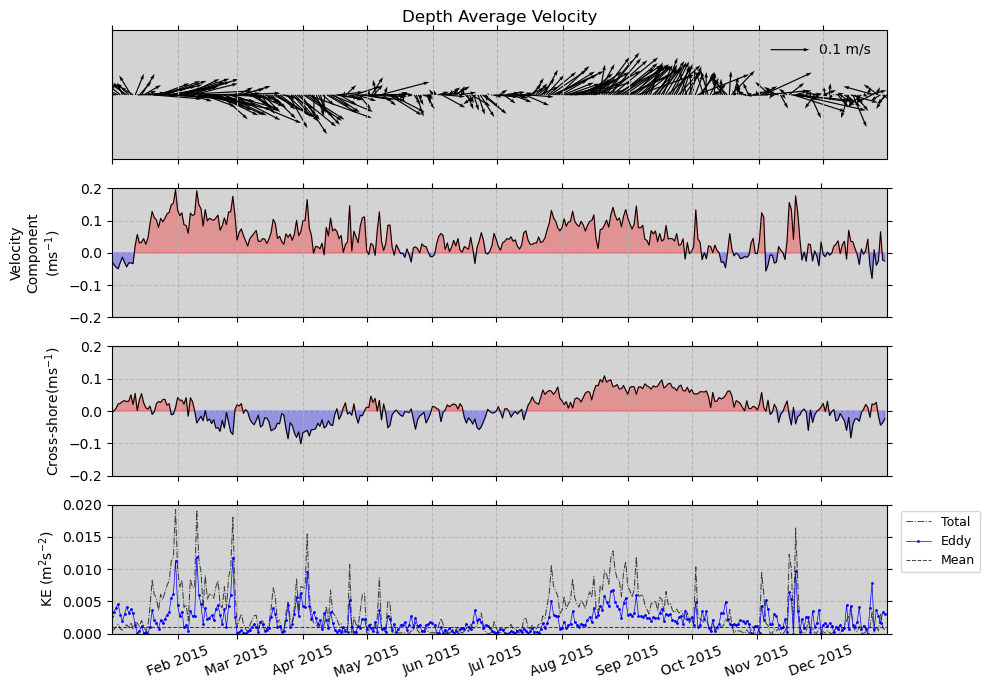

In [59]:
# Create figure
fig, axes = plt.subplots(4,1,figsize=(10, 7))
ax1,ax2,ax3,ax4 = axes.flatten()

#--- Subplot 1 ---# 

# Plot the velocity vectors
q = ax1.quiver(time_daily_dt, np.zeros_like(time_daily_dt), U_shelf_daily, V_shelf_daily, scale=2, width=0.0015)

# Set axis attributes
ax1.set_title("Depth Average Velocity")
ax1.set_xlim([time_daily_dt[0], time_daily_dt[-1]])
ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.tick_params(top=True, bottom=True, left=False, right=False,
            direction='out', length=3.5)
ax1.grid(True, linestyle='--')

# Set quiver legend
ax1.quiverkey(q, X=0.9, Y=0.85, U=0.1, label='0.1 m/s', labelpos='E', coordinates='axes')

# Set the background color of the axes
ax1.set_facecolor('lightgray')

#--- Subplot 2 ---#  

# Plot black lines with different linestyles
ax2.plot(time_daily_dt, U_shelf_daily, '-', label="Along-shore", color='black', linewidth=0.75, markersize=2)

# Shading: Along-shore
ax2.fill_between(time_daily_dt, U_shelf_daily, 0,
                 where=(U_shelf_daily > 0), interpolate=True, color='red', alpha=0.3)
ax2.fill_between(time_daily_dt, U_shelf_daily, 0,
                 where=(U_shelf_daily < 0), interpolate=True, color='blue', alpha=0.3)

# Set legend
#ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax2.set_ylabel("Velocity\nComponent\n(ms$^{-1}$)")
ax2.set_xlim(time[0], time[-1])
ax2.set_xticklabels([])
ax2.set_ylim([-0.2, 0.2])
ax2.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax2.grid(True, linestyle='--', alpha=0.8)
ax2.set_facecolor('lightgray')

#--- Subplot 3 ---# 

# Plot black lines with different linestyles
ax3.plot(time_daily_dt, V_shelf_daily, '-', label="Cross-shore", color='black', linewidth=0.75, markersize=2)

# Shading: Cross-shore
ax3.fill_between(time_daily_dt, V_shelf_daily, 0,
                 where=(V_shelf_daily > 0), interpolate=True, color='red', alpha=0.3)
ax3.fill_between(time_daily_dt, V_shelf_daily, 0,
                 where=(V_shelf_daily < 0), interpolate=True, color='blue', alpha=0.3)

# Set legend
#ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax3.set_ylabel("Cross-shore(ms$^{-1}$)")
ax3.set_xlim(time[0], time[-1])
ax3.set_xticklabels([])
ax3.set_ylim([-0.2, 0.2])
ax3.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
ax3.grid(True, linestyle='--', alpha=0.8)
ax3.set_facecolor('lightgray')

#--- Subplot 4 ---#  

# Plot depth and daily average along- and cross-shore components
ax4.plot(time_daily_dt, KE_tot_depth, '-.', label="Total", color='k', linewidth=0.75, markersize=2, alpha = 0.7)
ax4.plot(time_daily_dt, EKE_depth, '.-', label="Eddy", color='blue', linewidth=0.5, markersize=2)
ax4.axhline(MKE_depth, linestyle='--' ,label="Mean",color='k', linewidth=0.75,alpha=0.7)
 
# Set legend
ax4.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax4.set_ylabel("KE (m$^2$s$^{-2}$)")
ax4.set_xlim(time[0], time[-1])
ax4.set_ylim([0, 0.02])
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax4.get_xticklabels(), rotation=20)
ax4.tick_params(top=True, bottom=True, left=True, right=True,
            direction='out', length=3.5)
ax4.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax4.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Preform scale analysis

In [ ]:
# Set parameters
ndepth,ntime = np.shape(U)
lag = ntime
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/sec
M = 20                                                       # Specifies number of windows to divide the data into for the Welch method
p = ntime // M                                               # Specifies window length, i.e., number of data points in each segment
nfft = (p // 2 + 1) if (p % 2 == 0) else ((p - 1) // 2)      # Specifies number of positive frequency bins in the resulting power spectrum
units = 'Hz'

# Define frequency range for slope fitting (sub-interial and super-inertial)
fmin_sub = 6*10**(-2) 
fmax_sub = 6*10**(-1) 
fmin_sup = 2*10**(0)
fmax_sup = 1.25*10**(1)

#Convert to seconds since start time
t0 = time[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time])

#--- Along-shore Velocity --- #

# Initialize arrays 
autocorr_u       = np.zeros((ntime,ndepth))
time_scale_u     = np.zeros((ntime,ndepth))
L_t_u            = np.zeros((ndepth))
S_u              = np.zeros((nfft,ndepth))
CI_u             = np.zeros((nfft,2,ndepth))
S_u_slope_sub    = np.zeros((ndepth))
S_u_slope_unc_sub = np.zeros((ndepth))
S_u_slope_sup    = np.zeros((ndepth))
S_u_slope_unc_sup = np.zeros((ndepth))
E_scale_u        = np.zeros((ndepth))

# Set counter
cn_depth = 0 

# Loop through depths 
for idepth in range(0,ndepth):
    
    # Set progress bar
    progress = (idepth) / (len(depth))
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()
        
    # Initialize the ith time series 
    data_ts = U_shelf[idepth,:]

    # Remove annual and semi-annual cycle 
    hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
    data_ts_rm = data_ts - hfit

    # Detrend data record 
    data_dt = detrend(data_ts_rm, time_elapsed, mean = 0)

    # Compute autocorrelation function
    autocorr_u[:,cn_depth], _, _, _, time_scale_u[:,cn_depth], _ = compute_autocorr_optimize(data_dt, time_elapsed, lag, estimator, 0)

    # Compute the decorrelation scale
    L_t_u[cn_depth] = compute_decor_scale_optimize(autocorr_u[:,cn_depth],time_scale_u[:,cn_depth],T,'unbiased',0)

    # Compute frequency power spectrum 
    data_interp = np.interp(time_elapsed, time_elapsed[~data_dt.mask], data_dt[~data_dt.mask])
    S_u[:,cn_depth], f_u, CI_u[:,:,cn_depth], _ = spectrum1D_frequency(data_interp, T, M, units)

    # Compute the energy-containing scales
    f_zero = f_u[f_u > 0]
    S_zero = S_u[f_u > 0,cn_depth]
    spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
    E_scale_u[cn_depth] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

    # Compute the sub-inertial and super inertial spectral slope
    f_cpd = f_u*(60)*(60)*(24)
    S_u_slope_sub[cn_depth], S_u_slope_unc_sub[cn_depth], S_u_fit_sub, f_range_sub = spectral_slope(f_cpd, S_u[:,cn_depth], fmin_sub, fmax_sub)
    S_u_slope_sup[cn_depth], S_u_slope_unc_sup[cn_depth], S_u_fit_sup, f_range_sup = spectral_slope(f_cpd, S_u[:,cn_depth], fmin_sup, fmax_sup)

    # Plot Spectral slope 
    if option_plot == True: 
        
        plt.figure(figsize=(8, 5))
        plt.loglog(f_cpd, S_u[:,cn_depth], label='PSD')
        plt.loglog(f_range_sub, S_u_fit_sub, '--r', label=f'Fit: slope = {S_u_slope_sub[cn_depth]:.2f} ± {S_u_slope_unc_sub[cn_depth]:.2f}')
        plt.loglog(f_range_sup, S_u_fit_sup, '--b', label=f'Fit: slope = {S_u_slope_sup[cn_depth]:.2f} ± {S_u_slope_unc_sup[cn_depth]:.2f}')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('PSD')
        plt.title('Spectral Slope Test')
        plt.legend()
        plt.grid(True, which='both', ls='--')
        plt.tight_layout()
        plt.show()

    # Compute structure function
    S_i, lag_i = compute_structure_function(data_ts, lag, orders=[1, 2, 3, 4])

    # Set longitude counter
    cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_u = L_t_u*(1/60)*(1/60)*(1/24)

#--- Cross-shore Velocity ---# 

# Initialize arrays 
autocorr_v        = np.zeros((ntime,ndepth))
time_scale_v      = np.zeros((ntime,ndepth))
L_t_v             = np.zeros((ndepth))
S_v               = np.zeros((nfft,ndepth))
CI_v              = np.zeros((nfft,2,ndepth))
S_v_slope_sub     = np.zeros((ndepth))
S_v_slope_unc_sub = np.zeros((ndepth))
S_v_slope_sup     = np.zeros((ndepth))
S_v_slope_unc_sup = np.zeros((ndepth))
E_scale_v         = np.zeros((ndepth))

# Set counter
cn_depth = 0 

# Loop through depths 
for idepth in range(0,ndepth):
    
    # Set progress bar
    progress = (idepth) / (len(depth))
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()
        
    # Initialize the ith time series 
    data_ts = V_shelf[idepth,:]

    # Remove annual and semi-annual cycle 
    hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
    data_ts_rm = data_ts - hfit

    # Detrend data record 
    data_dt = detrend(data_ts_rm, time_elapsed, mean = 0)

    # Compute autocorrelation function
    autocorr_v[:,cn_depth], _, _, _, time_scale_v[:,cn_depth], _ = compute_autocorr_optimize(data_dt, time_elapsed, lag, estimator, 0)

    # Compute the decorrelation scale
    L_t_v[cn_depth] = compute_decor_scale_optimize(autocorr_v[:,cn_depth],time_scale_v[:,cn_depth],T,'unbiased',0)

    # Compute frequency power spectrum 
    data_interp = np.interp(time_elapsed, time_elapsed[~data_dt.mask], data_dt[~data_dt.mask])
    S_v[:,cn_depth], f_v, CI_v[:,:,cn_depth], _ = spectrum1D_frequency(data_interp, T, M, units)

    # Compute the energy-containing scales
    f_zero = f_v[f_v > 0]
    S_zero = S_v[f_v > 0,cn_depth]
    spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
    E_scale_v[cn_depth] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

    # Compute the sub-inertial and super inertial spectral slope
    f_cpd = f_v*(60)*(60)*(24)
    S_v_slope_sub[cn_depth], S_v_slope_unc_sub[cn_depth], S_v_fit_sub, f_range_sub = spectral_slope(f_cpd, S_v[:,cn_depth], fmin_sub, fmax_sub)
    S_v_slope_sup[cn_depth], S_v_slope_unc_sup[cn_depth], S_v_fit_sup, f_range_sup = spectral_slope(f_cpd, S_v[:,cn_depth], fmin_sup, fmax_sup)

    # Compute structure function
    #S_i, lag_i = compute_structure_function(data_m, lag, orders=[1, 2, 3, 4])

    # Set longitude counter
    cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_v = L_t_v*(1/60)*(1/60)*(1/24)

#--- EKE ---# 

# Initialize arrays 
autocorr_eke       = np.zeros((ntime,ndepth))
time_scale_eke     = np.zeros((ntime,ndepth))
L_t_eke            = np.zeros((ndepth))
S_eke              = np.zeros((nfft,ndepth))
CI_eke             = np.zeros((nfft,2,ndepth))
S_eke_slope_sub    = np.zeros((ndepth))
S_eke_slope_unc_sub = np.zeros((ndepth))
S_eke_slope_sup    = np.zeros((ndepth))
S_eke_slope_unc_sup = np.zeros((ndepth))
E_scale_eke        = np.zeros((ndepth))

# Set counter
cn_depth = 0 

# Loop through depths 
for idepth in range(0,ndepth):
    
    # Set progress bar
    progress = (idepth) / (len(depth))
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()
        
    # Initialize the ith time series 
    data_ts = EKE[idepth,:]

    # Remove annual and semi-annual cycle 
    hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
    data_ts_rm = data_ts - hfit

    # Detrend data record 
    data_dt = detrend(data_ts_rm, time_elapsed, mean = 0)

    # Compute autocorrelation function
    autocorr_eke[:,cn_depth], _, _, _, time_scale_eke[:,cn_depth], _ = compute_autocorr_optimize(data_dt, time_elapsed, lag, estimator, 0)

    # Compute the decorrelation scale
    L_t_eke[cn_depth] = compute_decor_scale_optimize(autocorr_eke[:,cn_depth],time_scale_eke[:,cn_depth],T,'unbiased',0)

    # Compute frequency power spectrum 
    data_interp = np.interp(time_elapsed, time_elapsed[~data_dt.mask], data_dt[~data_dt.mask])
    S_eke[:,cn_depth], f_eke, CI_eke[:,:,cn_depth], _ = spectrum1D_frequency(data_interp, T, M, units)

    # Compute the energy-containing scales
    f_zero = f_eke[f_eke > 0]
    S_zero = S_eke[f_eke > 0,cn_depth]
    spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
    E_scale_eke[cn_depth] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

    # Compute the sub-inertial and super inertial spectral slope
    f_cpd = f_eke*(60)*(60)*(24)
    S_eke_slope_sub[cn_depth], S_eke_slope_unc_sub[cn_depth], S_eke_fit_sub, f_range_sub = spectral_slope(f_cpd, S_eke[:,cn_depth], fmin_sub, fmax_sub)
    S_eke_slope_sup[cn_depth], S_eke_slope_unc_sup[cn_depth], S_eke_fit_sup, f_range_sup = spectral_slope(f_cpd, S_eke[:,cn_depth], fmin_sup, fmax_sup)

    # Compute structure function
    #S_i, lag_i = compute_structure_function(data_m, lag, orders=[1, 2, 3, 4])

    # Set longitude counter
    cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_eke = L_t_eke*(1/60)*(1/60)*(1/24)

Progress: 0.0%

Progress: 98.2%

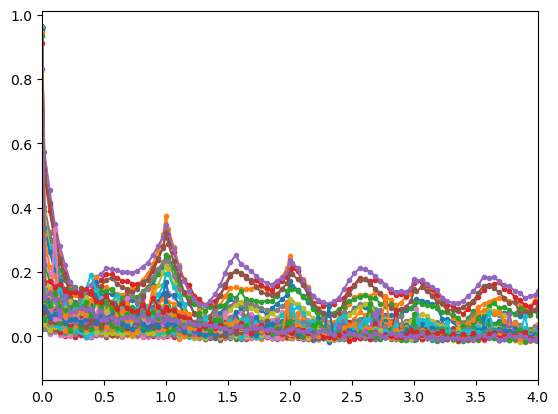

In [8]:
plt.plot(time_scale_eke*(1/60)*(1/60)*(1/24),autocorr_eke,'.-')
plt.xlim([0,4])
plt.show()

Plot a comparison of the decorrelation scales from each of the variables

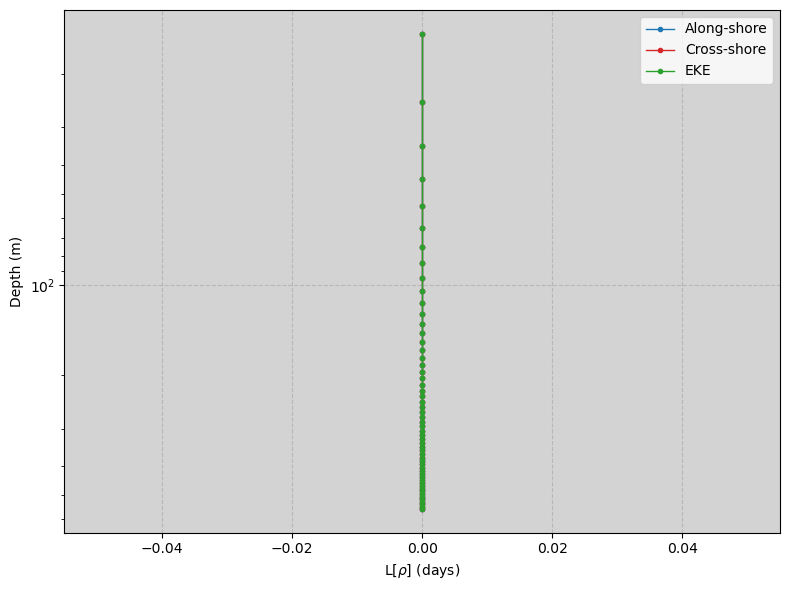

In [29]:
# Create the figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Plot the decorrelation length scale
ax.semilogy(Lt_u, depth, '.-', color='tab:blue', linewidth=1,label='Along-shore')
ax.semilogy(Lt_v, depth, '.-', color='tab:red', linewidth=1, label='Cross-shore')
ax.semilogy(Lt_eke, depth, '.-', color='tab:green', linewidth=1, label='EKE')

# Set figure attributes
ax.set_xlabel(r'L[$\rho$] (days)')
ax.set_ylabel('Depth (m)')
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Reverse the direction of the x-axis 
ax.invert_yaxis() 

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Compute the decorrelation scale of the depth averaged velocity and EKE

In [46]:
# Set parameters
ntime = len(U_shelf_depth)
lag = ntime
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/sec
M = 20                                                       # Specifies number of windows to divide the data into for the Welch method
p = ntime // M                                               # Specifies window length, i.e., number of data points in each segment
nfft = (p // 2 + 1) if (p % 2 == 0) else ((p - 1) // 2)      # Specifies number of positive frequency bins in the resulting power spectrum
units = 'Hz'
option_plot = 1

#Convert to seconds since start time
t0 = time[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time])

#----------------------------------------------------#
#------------- Along-shore Velocity -----------------#
#----------------------------------------------------#

# Initialize the ith time series 
data_ts = U_shelf_depth

# Remove annual and semi-annual cycle 
hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
data_ts_rm = data_ts - hfit

# Detrend data record 
data_dt = detrend(data_ts_rm, time_elapsed, mean = 0)

# Compute autocorrelation function
autocorr_ud, _, _, _, time_scale_ud, _ = compute_autocorr_optimize(data_dt, time_elapsed, lag, estimator, 0)

# Compute the decorrelation scale
L_t_ud = compute_decor_scale_optimize(autocorr_ud,time_scale_ud,T,'unbiased',0)

# Compute frequency power spectrum 
data_interp = np.interp(time_elapsed, time_elapsed[~data_dt.mask], data_dt[~data_dt.mask])
S_ud, f_ud, CI_ud, _ = spectrum1D_frequency(data_interp, T, M, units)

# Compute the energy-containing scales
f_zero = f_ud[f_ud > 0]
S_zero = S_ud[f_ud > 0]
spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
E_scale_ud = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

# Compute the sub-inertial and super inertial spectral slope
f_cpd = f_ud*(60)*(60)*(24)
S_ud_slope_sub, S_ud_slope_unc_sub, S_ud_fit_sub, f_range_sub = spectral_slope(f_cpd, S_ud, fmin_sub, fmax_sub)
S_ud_slope_sup, S_ud_slope_unc_sup, S_ud_fit_sup, f_range_sup = spectral_slope(f_cpd, S_ud, fmin_sup, fmax_sup)

# Compute structure function
data_interp = np.interp(time_elapsed, time_elapsed[~data_ts.mask], data_ts[~data_ts.mask])
struct_ud, lag_ud = compute_structure_function(data_interp, lag, orders=[1, 2, 3, 4])

# Set longitude counter
cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_ud = L_t_ud*(1/60)*(1/60)*(1/24)

#----------------------------------------------------#
#------------- Cross-shore Velocity -----------------#
#----------------------------------------------------#

# Initialize the ith time series 
data_ts = V_shelf_depth

# Remove annual and semi-annual cycle 
hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
data_ts_rm = data_ts - hfit

# Detrend data record 
data_dt = detrend(data_ts_rm, time_elapsed, mean = 0)

# Compute autocorrelation function
autocorr_vd, _, _, _, time_scale_vd, _ = compute_autocorr_optimize(data_dt, time_elapsed, lag, estimator, 0)

# Compute the decorrelation scale
L_t_vd = compute_decor_scale_optimize(autocorr_vd,time_scale_vd,T,'unbiased',0)

# Compute frequency power spectrum 
data_interp = np.interp(time_elapsed, time_elapsed[~data_dt.mask], data_dt[~data_dt.mask])
S_vd, f_vd, CI_vd, _ = spectrum1D_frequency(data_interp, T, M, units)

# Compute the energy-containing scales
f_zero = f_vd[f_vd > 0]
S_zero = S_vd[f_vd > 0]
spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
E_scale_vd = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

# Compute the sub-inertial and super inertial spectral slope
f_cpd = f_vd*(60)*(60)*(24)
S_vd_slope_sub, S_vd_slope_unc_sub, S_vd_fit_sub, f_range_sub = spectral_slope(f_cpd, S_vd, fmin_sub, fmax_sub)
S_vd_slope_sup, S_vd_slope_unc_sup, S_vd_fit_sup, f_range_sup = spectral_slope(f_cpd, S_vd, fmin_sup, fmax_sup)

# Compute structure function
data_interp = np.interp(time_elapsed, time_elapsed[~data_ts.mask], data_ts[~data_ts.mask])
struct_vd, lag_vd = compute_structure_function(data_interp, lag, orders=[1, 2, 3, 4])

# Set longitude counter
cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_vd = L_t_vd*(1/60)*(1/60)*(1/24)

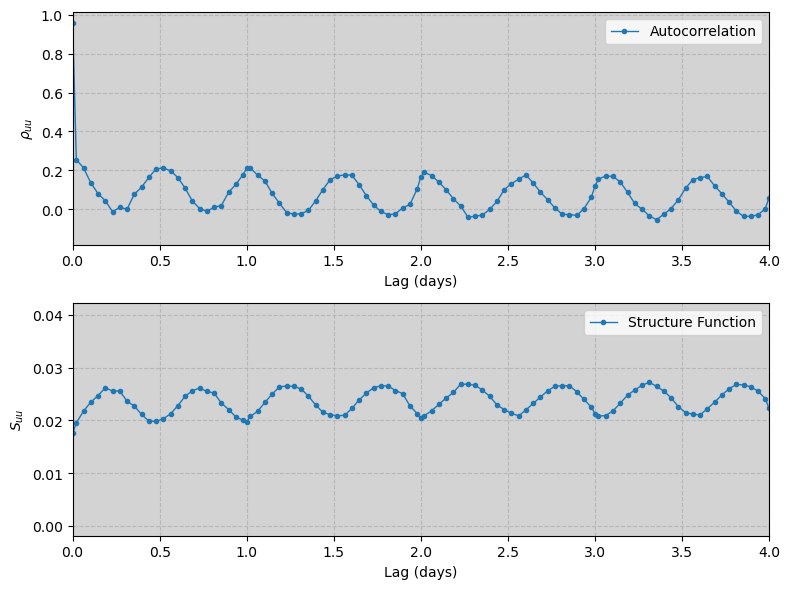

In [47]:
# Convert time scale to months
time_scale_days = time_scale_ud*(1/60)*(1/60)*(1/24)
lag_days = lag_ud*(1/60)*(1/60)*(1/24)

# Create the figure
fig = plt.figure(figsize=(8, 6))

#--- Subplot 1 ---# 
ax = fig.add_subplot(211)

# Plot the Autocorrelation Function
ax.plot(time_scale_days, autocorr_ud , '.-', color='tab:blue', linewidth=1,label='Autocorrelation')

# Set figure attributes
ax.set_xlabel(r'Lag (days)')
ax.set_ylabel(r'$\rho_{uu}$')
ax.set_xlim([0,4])
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Set the background color of the axes
ax.set_facecolor('lightgray')

#--- Subplot 1 ---# 
ax = fig.add_subplot(212)

# Plot the Structure Function
ax.plot(time_scale_days, struct_ud[2], '.-', color='tab:blue', linewidth=1, label='Structure Function')

# Set figure attributes
ax.set_xlabel(r'Lag (days)')
ax.set_ylabel(r'$S_{uu}$')
ax.set_xlim([0,4])
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

masked_array(data=[--, -0.10445990936505661, -0.09192863815724987, ...,
                   0.01697692904861727, -0.061939643328441936,
                   0.02340030310410767],
             mask=[ True, False, False, ..., False, False, False],
       fill_value=nan)

In [ ]:
print(Lt_ud)
print(Lt_vd)
print(E_scale_ud)
print(E_scale_vd)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [25]:
keys = struct_ud.keys()
print(keys) 

dict_keys([1, 2, 3, 4])


In [26]:
struct_ud[1]

array([0.02656058, 0.03319467, 0.0348495 , 0.03687626, 0.03690888,
       0.03762381, 0.0388626 , 0.03908226, 0.04037016, 0.04132776,
       0.04005788, 0.04088418, 0.04074543, 0.04079493, 0.04254592,
       0.0430579 , 0.04506066, 0.04661753, 0.04611248, 0.04659933,
       0.04755615, 0.0490305 , 0.0497569 , 0.04782698, 0.04688972,
       0.04781714, 0.04784823, 0.04852303, 0.04996316, 0.05079691,
       0.05146364, 0.05243451, 0.05328309, 0.05419114, 0.05377342,
       0.05361752, 0.05442927, 0.05427433, 0.05491387, 0.05546574,
       0.05675949, 0.05630098, 0.05486743, 0.05588022, 0.05697208,
       0.05729617, 0.05622462, 0.05599592, 0.05647415, 0.05557423,
       0.05684609, 0.05751721, 0.05757052, 0.05733004, 0.05661609,
       0.05707235, 0.05631244, 0.05676664, 0.05602228, 0.05685776,
       0.05677488, 0.05627147, 0.05579475, 0.05564006, 0.05646546,
       0.05810736, 0.05903205, 0.05693336, 0.0570975 , 0.05697688,
       0.05767913, 0.05813948, 0.05909856, 0.05972964, 0.06025